In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

# Normalizacion
from sklearn.preprocessing import MinMaxScaler

# Train, Test
from sklearn.model_selection import train_test_split

# Metricas
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout, LSTM
from keras.callbacks import EarlyStopping
from itertools import combinations

In [3]:
nba_teams = teams.get_teams()
team_ids = [team['id'] for team in nba_teams]
# Crear una lista para almacenar todos los dataframes de gamefinder
dfs = []

# Obtener el gamefinder para cada equipo y convertirlo en DataFrame
for team in nba_teams:
    team_id = team['id']
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id)
    games = gamefinder.get_data_frames()[0]
    dfs.append(games)

# Concatenar todos los DataFrames en uno solo
all_games = pd.concat(dfs, ignore_index=True)
all_games_local = all_games[all_games['MATCHUP'].str.contains('vs')]
all_games_visitante = all_games[all_games['MATCHUP'].str.contains('@')]
df_combinado = pd.merge(all_games_local, all_games_visitante, on='GAME_ID', suffixes=('_local', '_visitante'))
df_combinado['WL_local'] = df_combinado['WL_local'].map({'W': 1, 'L': 0})
df_combinado['WL_visitante'] = df_combinado['WL_visitante'].map({'W': 1, 'L': 0})
df_combinado = df_combinado.dropna()

In [4]:
temporadas_validas = [str(i) for i in range(2015, 2025)]

# Filtrar el DataFrame para excluir filas con años no válidos en 'SEASON_ID_local'
df_10 = df_combinado[df_combinado['SEASON_ID_local'].astype(str).apply(lambda x: x[-4:] in temporadas_validas)]
# Lista de columnas con las que vamos a trabajar
columnas_seleccionadas = [
    'SEASON_ID_local', 'TEAM_ID_local','TEAM_ABBREVIATION_local','MATCHUP_local','GAME_DATE_local','WL_local', 'PTS_local',
    'FG_PCT_local', 'FG3_PCT_local', 'FT_PCT_local', 'REB_local', 'AST_local',
    'STL_local', 'BLK_local', 'TOV_local', 'PF_local',
    'TEAM_ID_visitante', 'TEAM_ABBREVIATION_local', 'PTS_visitante', 'FG_PCT_visitante', 'FG3_PCT_visitante',
    'FT_PCT_visitante', 'REB_visitante', 'AST_visitante', 'STL_visitante',
    'BLK_visitante', 'TOV_visitante', 'PF_visitante'
]

# Crear un nuevo DataFrame con solo las columnas seleccionadas utilizando .loc
df_seleccionado = df_10.loc[:, columnas_seleccionadas]

In [5]:
def Nombres_equipos(TEAM_LOCAL, TEAM_VISITANTE, df_seleccionado):
    nba_teams = teams.get_teams()
    try:
        equipo_local = next(team for team in nba_teams if team['abbreviation'] == TEAM_LOCAL)['id']
        equipo_visitante = next(team for team in nba_teams if team['abbreviation'] == TEAM_VISITANTE)['id']
    except StopIteration:
        raise ValueError("Una de las abreviaturas no es válida.")

    # Filtrar el dataframe original para obtener los dataframes de cada equipo
    df_equipo_local = df_seleccionado[df_seleccionado['TEAM_ID_local'] == equipo_local].copy()
    df_equipo_visitante = df_seleccionado[df_seleccionado['TEAM_ID_visitante'] == equipo_visitante].copy()
    
    df_equipo_local['GAME_DATE_local'] = pd.to_datetime(df_equipo_local['GAME_DATE_local'])
    
    df_equipo_local = df_equipo_local.sort_values(by='GAME_DATE_local')
    df_equipo_local.reset_index(drop=True, inplace=True)
    
    df_equipo_visitante['GAME_DATE_local'] = pd.to_datetime(df_equipo_visitante['GAME_DATE_local'])
    
    df_equipo_visitante = df_equipo_visitante.sort_values(by='GAME_DATE_local')
    df_equipo_visitante.reset_index(drop=True, inplace=True)
    return df_equipo_local, df_equipo_visitante


In [6]:
df_equipo_local, df_equipo_visitante = Nombres_equipos('BOS', 'LAL', df_seleccionado)

In [7]:
df_equipo_local

,SEASON_ID_local,TEAM_ID_local,TEAM_ABBREVIATION_local,MATCHUP_local,GAME_DATE_local,WL_local,PTS_local,FG_PCT_local,FG3_PCT_local,FT_PCT_local,...,PTS_visitante,FG_PCT_visitante,FG3_PCT_visitante,FT_PCT_visitante,REB_visitante,AST_visitante,STL_visitante,BLK_visitante,TOV_visitante,PF_visitante
0,22015,1610612738,BOS,BOS vs. PHI,2015-07-12,1.0,85,0.362,0.348,0.844,...,76,0.351,0.421,0.800,42.0,12,8.0,5,15,29
1,22015,1610612738,BOS,BOS vs. MIA,2015-07-14,1.0,101,0.449,0.462,0.818,...,69,0.348,0.348,0.684,36.0,12,4.0,5,15,27
2,22015,1610612738,BOS,BOS vs. POR,2015-07-16,1.0,91,0.397,0.375,0.857,...,85,0.466,0.438,0.769,40.0,16,3.0,3,14,22
3,22015,1610612738,BOS,BOS vs. SAS,2015-07-18,0.0,93,0.429,0.286,0.679,...,95,0.465,0.333,0.852,40.0,8,4.0,6,12,30
4,12015,1610612738,BOS,BOS vs. BKN,2015-10-19,1.0,111,0.513,0.400,0.731,...,105,0.462,0.414,0.700,37.0,22,11.0,2,22,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,42023,1610612738,BOS,BOS vs. MIA,2024-04-24,0.0,101,0.463,0.375,0.714,...,111,0.493,0.535,0.778,40.0,25,9.0,1,12,22
467,42023,1610612738,BOS,BOS vs. MIA,2024-05-01,1.0,118,0.545,0.400,0.667,...,84,0.414,0.103,0.900,29.0,20,4.0,0,6,17
468,42023,1610612738,BOS,BOS vs. CLE,2024-05-07,1.0,120,0.489,0.391,0.857,...,95,0.411,0.262,0.769,38.0,19,2.0,3,5,18
469,42023,1610612738,BOS,BOS vs. CLE,2024-05-09,0.0,94,0.413,0.229,0.833,...,118,0.547,0.464,0.688,44.0,24,4.0,3,10,20


In [8]:
df_equipo_visitante

,SEASON_ID_local,TEAM_ID_local,TEAM_ABBREVIATION_local,MATCHUP_local,GAME_DATE_local,WL_local,PTS_local,FG_PCT_local,FG3_PCT_local,FT_PCT_local,...,PTS_visitante,FG_PCT_visitante,FG3_PCT_visitante,FT_PCT_visitante,REB_visitante,AST_visitante,STL_visitante,BLK_visitante,TOV_visitante,PF_visitante
0,22015,1610612755,PHI,PHI vs. LAL,2015-07-11,0.0,60,0.286,0.320,0.600,...,68,0.393,0.214,0.773,41.0,5,8.0,6,15,23
1,22015,1610612752,NYK,NYK vs. LAL,2015-07-13,1.0,76,0.397,0.167,0.690,...,66,0.305,0.188,0.771,31.0,6,10.0,1,20,31
2,22015,1610612758,SAC,SAC vs. LAL,2015-10-30,1.0,132,0.515,0.273,0.733,...,114,0.461,0.324,0.778,37.0,20,7.0,9,19,24
3,22015,1610612751,BKN,BKN vs. LAL,2015-11-06,0.0,98,0.430,0.158,0.750,...,104,0.423,0.304,0.775,40.0,14,9.0,6,15,22
4,22015,1610612752,NYK,NYK vs. LAL,2015-11-08,1.0,99,0.393,0.333,0.828,...,95,0.383,0.333,0.609,46.0,19,7.0,3,9,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,22023,1610612740,NOP,NOP vs. LAL,2024-04-14,0.0,108,0.477,0.405,0.786,...,124,0.552,0.379,0.944,39.0,32,12.0,3,14,13
421,52023,1610612740,NOP,NOP vs. LAL,2024-04-16,0.0,106,0.462,0.300,0.733,...,110,0.417,0.400,0.897,41.0,24,8.0,7,8,12
422,42023,1610612743,DEN,DEN vs. LAL,2024-04-20,1.0,114,0.461,0.357,0.833,...,103,0.494,0.276,0.895,40.0,22,3.0,7,12,15
423,42023,1610612743,DEN,DEN vs. LAL,2024-04-22,1.0,101,0.443,0.235,0.882,...,99,0.487,0.433,0.769,38.0,24,6.0,3,14,20


In [9]:
df_equipo_local.columns

Index(['SEASON_ID_local', 'TEAM_ID_local', 'TEAM_ABBREVIATION_local',
       'MATCHUP_local', 'GAME_DATE_local', 'WL_local', 'PTS_local',
       'FG_PCT_local', 'FG3_PCT_local', 'FT_PCT_local', 'REB_local',
       'AST_local', 'STL_local', 'BLK_local', 'TOV_local', 'PF_local',
       'TEAM_ID_visitante', 'TEAM_ABBREVIATION_local', 'PTS_visitante',
       'FG_PCT_visitante', 'FG3_PCT_visitante', 'FT_PCT_visitante',
       'REB_visitante', 'AST_visitante', 'STL_visitante', 'BLK_visitante',
       'TOV_visitante', 'PF_visitante'],
      dtype='object')

### FORECASTING EQUIPO LOCAL

In [10]:
T = 10 # Segmentos
X = list()
y = list()

# Supongamos que quieres añadir las columnas 'AST' y 'REB' además de 'PTS'
columnas_adicionales = ['FG_PCT_local','FG3_PCT_local','FT_PCT_local', "WL_local", "AST_local", "REB_local"]  # Añade aquí las columnas que quieras incluir

for t in range(len(df_equipo_local) - T):
    
    # Toma valores de X de t en t con stride de 1 para todas las columnas deseadas
    x = df_equipo_local[columnas_adicionales][t : t + T].values
    X.append(x)
    
    # Toma los valores de 'PTS' para la etiqueta y
    y_ = df_equipo_local['WL_local'][t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones para el modelo
# Ahora, 'X' tendrá una dimensión adicional para las características
X = np.array(X).reshape(-1, T * len(columnas_adicionales), 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")  # Imprime las formas de los arrays


X: (461, 60, 1)	y: (461,)


In [11]:
# Número de características que estás utilizando
num_caracteristicas = 6  # Asegúrate de que esto coincida con tus datos de entrada

model = Sequential()

# Capa de entrada con la forma correcta
model.add(Input(shape=(T*len(columnas_adicionales), 1)))

# Capa LSTM configurada para el número correcto de características
model.add(LSTM(units=256))

# Capas densas con activación 'relu'
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=32, activation="relu"))

# Capa de salida con el número correcto de unidades
# Asegúrate de que esto coincida con la dimensión de tus etiquetas 'y'
model.add(Dense(units=1, activation="sigmoid"))  # Cambia esto si tus etiquetas 'y' tienen más dimensiones

# Compilación del modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])

# Resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,457 (1.17 MB)

 Trainable params: 307,457 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'equipos' is not defined

In [11]:
history = model.fit(x = X[:400],
                    y = y[:400],
                    validation_data = (X[400:], y[400:]),
                    #callbacks = [EarlyStopping(min_delta = 0.0001, patience = 50)],
                    epochs = 200)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7147 - loss: 0.6255 - val_accuracy: 0.7833 - val_loss: 0.6225
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6921 - loss: 0.6395 - val_accuracy: 0.7833 - val_loss: 0.5413
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6806 - loss: 0.6304 - val_accuracy: 0.7833 - val_loss: 0.5522
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6831 - loss: 0.6267 - val_accuracy: 0.7833 - val_loss: 0.5500
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7199 - loss: 0.6005 - val_accuracy: 0.7833 - val_loss: 0.5555
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6709 - loss: 0.6361 - val_accuracy: 0.7833 - val_loss: 0.5647
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6659 - loss: 0.6368 - val_accuracy: 0.7833 - val_loss: 0.5374
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6625 - loss: 0.6441 - val_accuracy: 0.

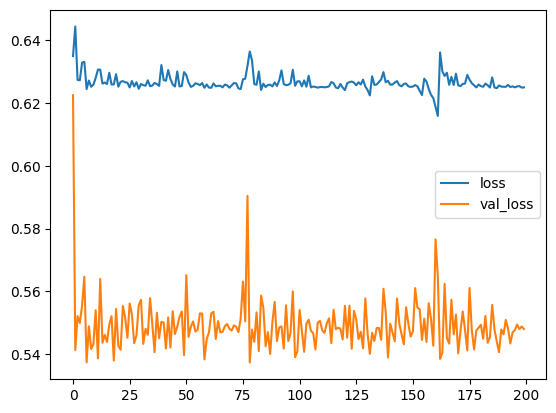

In [12]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
#plt.plot(history.history['binary_accuracy'], label = 'binary_accuracy')
plt.legend()
#plt.ylim(0, 300)
plt.show()

In [13]:
# "1 - Step Predictions"

# Toma un valor y predice el siguiente

validation_target = y[400:]       #y[300:]
validation_predictions = []

# Asumiendo que 'T' es el número de pasos de tiempo y 'num_caracteristicas' es el número de características
i = 400

while len(validation_predictions) < len(validation_target):
    
    # Reshape X[i] para que tenga tres dimensiones: [1, T, num_caracteristicas]
    # Aquí, 'num_caracteristicas' debe coincidir con el número de características que tu modelo espera
    p = model.predict(X[i].reshape(1, T * num_caracteristicas))[0, 0]
    i += 1
    
    validation_predictions.append(p)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

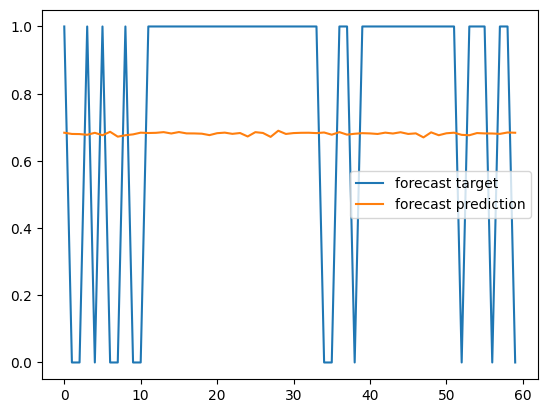

In [14]:
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast prediction")
plt.legend()
#plt.ylim(0, 1)

#plt.xlim(980, 1000)
plt.show()

### RANDOM FOREST

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Separa las características y la variable objetivo
X = df_equipo_local[['mo', 'FG3_PCT_local']]
y = df_equipo_local['WL_local']

# Divide el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea el modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrena el modelomo
model.fit(X_train, y_train)

# Haz predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evalúa el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print('Precisión:', accuracy)

Precisión: 0.7659574468085106


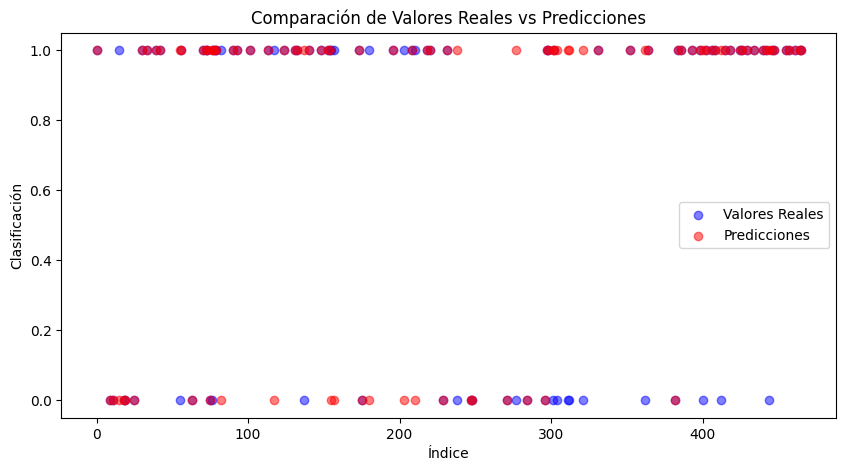

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya has entrenado tu modelo y realizado predicciones con X_test

# Convierte las predicciones y los valores reales en un DataFrame para una manipulación fácil
resultados = pd.DataFrame({'Reales': y_test, 'Predicciones': y_pred})

# Grafica los resultados
plt.figure(figsize=(10,5))
plt.scatter(resultados.index, resultados['Reales'], color='blue', label='Valores Reales', alpha=0.5)
plt.scatter(resultados.index, resultados['Predicciones'], color='red', label='Predicciones', alpha=0.5)
plt.title('Comparación de Valores Reales vs Predicciones')
plt.xlabel('Índice')
plt.ylabel('Clasificación')
plt.legend()
plt.show()
